# Data Ingestion

## Copy CSV files to S3

In [2]:
# Assume all the pre-requisites were set up 
%store -r setup_instance_check_passed
%store -r setup_dependencies_passed
%store -r setup_s3_bucket_passed
%store -r setup_iam_roles_passed


In [3]:
# Load Libraries
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [4]:
# Public Data
!aws s3 ls s3://ads508team5/

# Copy Datasets from :
# Source of data
s3_public_path_tweeter = "s3://ads508team5/tweeter"
s3_public_path_nyt = "s3://ads508team5/nyt"
s3_public_path_cities = "s3://ads508team5/cities"

# Destination Data:
s3_private_path_tweeter = "s3://{}/ADS508_project/tweeter".format(bucket)
s3_private_path_nyt = "s3://{}/ADS508_project/nyt".format(bucket)
s3_private_path_cities = "s3://{}/ADS508_project/cities".format(bucket)


# Copy datasets
!aws s3 cp --recursive $s3_public_path_tweeter/ $s3_private_path_tweeter/ --exclude "*" --include "hashtag_donaldtrump.csv"
!aws s3 cp --recursive $s3_public_path_tweeter/ $s3_private_path_tweeter/ --exclude "*" --include "hashtag_joebiden.csv"
!aws s3 cp --recursive $s3_public_path_nyt/ $s3_private_path_nyt/ --exclude "*" --include "nyt-comments-2020.csv"
!aws s3 cp --recursive $s3_public_path_cities/ $s3_private_path_cities/ --exclude "*" --include "uscities.csv"

                           PRE cities/
                           PRE nyt/
                           PRE tweeter/
copy: s3://ads508team5/tweeter/hashtag_donaldtrump.csv to s3://sagemaker-us-east-1-975050119017/ADS508_project/tweeter/hashtag_donaldtrump.csv
copy: s3://ads508team5/tweeter/hashtag_joebiden.csv to s3://sagemaker-us-east-1-975050119017/ADS508_project/tweeter/hashtag_joebiden.csv
copy: s3://ads508team5/nyt/nyt-comments-2020.csv to s3://sagemaker-us-east-1-975050119017/ADS508_project/nyt/nyt-comments-2020.csv
copy: s3://ads508team5/cities/uscities.csv to s3://sagemaker-us-east-1-975050119017/ADS508_project/cities/uscities.csv


## Create Database, Tables and Parquets
### Database

In [5]:
# Setup and check pre-requisites to create Database
ingest_create_athena_db_passed = False

!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [6]:

# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

# Create Connection
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [7]:
# Create Database
database_name = "dbpoliticpulsecomment"

statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)

pd.read_sql(statement, conn)

# Verify DB successfully created
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(5)


,database_name
0,dbpoliticpulsecomment
1,default


In [8]:
# End of Create Database
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

### Tables

In [9]:
# Create Tweeter Tables
table_name_csv = "tweeter"
s3_private_path_tweeter = "s3://{}/ADS508_project/tweeter".format(bucket)

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
  created_at TIMESTAMP,
  tweet_id FLOAT,
  tweet VARCHAR(250),
  likes INT,
  retweet_count INT,
  source VARCHAR(45),
  user_id INT,
  user_name VARCHAR(250),
  user_screen_name VARCHAR(45),
  user_description VARCHAR(250),
  user_join_date TIMESTAMP,
  user_followers_count INT,
  user_location VARCHAR(45),
  lat FLOAT,
  long FLOAT,
  city VARCHAR(45),
  country VARCHAR(45),
  continent VARCHAR(45),
  state VARCHAR(45),
  state_code VARCHAR(45),
  collected_at VARCHAR(45)
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_private_path_tweeter
)

pd.read_sql(statement, conn)


""


In [10]:
# testing hashtag_donaldtrump.csv tweet
tweet = "You get a tie! And you get a tie! #Trump ‘s rally #Iowa https://t.co/jJalUUmh5D"
# testing hashtag_joebiden.csv tweet
tweet = "@chrislongview Watching and setting dvr. Let’s give him bonus ratings!! #JoeBiden"


statement = """SELECT * FROM {}.{}
    WHERE tweet = '{}' LIMIT 100""".format(
    database_name, table_name_csv, tweet
)

df = pd.read_sql(statement, conn)
df.head(5)


,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,None,1.316529e+18,@chrislongview Watching and setting dvr. Let’s...,0,0,Twitter for iPhone,None,Michelle Ferg,MichelleFerg4,,...,27,,None,None,,,,,,00:01.6


In [11]:
# Create NYT comment Table
table_name_csv = "nyt_comment"
s3_private_path_nyt = "s3://{}/ADS508_project/nyt".format(bucket)


statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{} (
  commentID INT,
  status VARCHAR(20),
  commentSequence INT,
  userID INT,
  userDisplayName VARCHAR(45),
  userLocation VARCHAR(45),
  userTitle VARCHAR(10),
  commentBody VARCHAR(500),
  createDate TIMESTAMP,
  updateDate TIMESTAMP,
  approveDate TIMESTAMP,
  recommendation INT,
  replyCount INT,
  editorsSelection VARCHAR(20),
  parentID INT,
  parentUserDisplayName VARCHAR(45),
  depth INT,
  commentType VARCHAR(20),
  trusted VARCHAR(20),
  recommendedFlag VARCHAR(20),
  permID INT,
  isAnonymous VARCHAR(20),
  articleID VARCHAR(150)
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_private_path_nyt
)

pd.read_sql(statement, conn)


""


In [12]:
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,tab_name
0,comment
1,comment_parquet
2,nyt_comment
3,tweeter
4,uscities


In [13]:
commentBody = "@Philip Brown Agree 110%."

statement = """SELECT * FROM {}.{}
    WHERE commentBody = '{}' LIMIT 100""".format(
    database_name, table_name_csv, commentBody
)

df = pd.read_sql(statement, conn)
df.head(5)


,commentid,status,commentsequence,userid,userdisplayname,userlocation,usertitle,commentbody,createdate,updatedate,...,editorsselection,parentid,parentuserdisplayname,depth,commenttype,trusted,recommendedflag,permid,isanonymous,articleid
0,104389709,approved,104389709,72038931,Anthony Monaghan,Narrabeen,,@Philip Brown Agree 110%.,2020-01-01 10:36:20,2020-01-01 21:18:55,...,False,104389536,Philip Brown,2,userReply,0,0,104389709,False,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...


In [14]:
# Create uscities table
table_name = "uscities"
s3_private_path_cities = "s3://{}/ADS508_project/cities".format(bucket)

statement = """
CREATE EXTERNAL TABLE IF NOT EXISTS {}.{} (
    city VARCHAR(45),
    state_id VARCHAR(2),
    state_name VARCHAR(30)
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')
""".format(
    database_name, table_name, s3_private_path_cities
)

pd.read_sql(statement, conn)


""


### Parquets
#### Feature Selection and Creation
Prior creating a parquet table, tweeter and NYT comment tables are going to be combined under Comment Table in Athena where a feature creation is going to be performed. When the table is combined, we selected some features that would be benefit to our goal.

Selected features which could help on train the model are comment_body, user_location, candidatepoll

In [15]:
table_comment = "comment"
table_tweeter = "tweeter"
table_nyt_comment = "nyt_comment"

# SQL Statement combine tweeter and NYT comment in the preparation to create parquet
statement = """
CREATE TABLE IF NOT EXISTS {}.{} AS (
SELECT DISTINCT
    tweet_id AS comment_id,
    tweet AS comment_body,
    user_id AS user_id,
    user_name AS user_name,
    user_location AS user_location,
    u.state_id AS user_state,
    created_at AS create_date,
    retweet_count AS reply_retweet,
    likes AS recommendation_like,
    'tweet' as source,
    (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'trump', ''))) / LENGTH('trump') AS trump_count,
    (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'biden', ''))) / LENGTH('biden') AS biden_count,
    CASE 
        WHEN 
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'biden', ''))) / LENGTH('biden') > 
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'trump', ''))) / LENGTH('trump') 
        THEN 'Biden'
        WHEN              
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'biden', ''))) / LENGTH('biden') < 
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'trump', ''))) / LENGTH('trump') 
        THEN 'Trump'
        ELSE NULL
    END AS candidatepoll
FROM
    {}.{}
LEFT JOIN
    dbpoliticpulsecomment.uscities u ON lower(user_location) = lower(u.city) OR 
    lower(user_location) = lower(u.state_name) OR 
    lower(user_location) = lower(u.state_id)
WHERE
    LENGTH(tweet) > 3
UNION
SELECT DISTINCT
    commentid AS comment_id,
    commentbody AS comment_body,
    userID AS user_id,
    userDisplayName AS user_name,
    userLocation AS user_location,
    u.state_id as user_state,
    createDate AS create_date,
    replyCount AS reply_retweet,
    recommendation AS recommendation_like,
    'nyt_comment' as source,
    (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'trump', ''))) / LENGTH('trump') AS trump_count,
    (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'biden', ''))) / LENGTH('biden') AS biden_count,
    CASE
        WHEN
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'biden', ''))) / LENGTH('biden') > 
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'trump', ''))) / LENGTH('trump') 
        THEN 'Biden'
        WHEN
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'biden', ''))) / LENGTH('biden') < 
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'trump', ''))) / LENGTH('trump') 
        THEN 'Trump'
        ELSE NULL
    END AS candidatepoll
FROM 
    {}.{}
LEFT JOIN
    dbpoliticpulsecomment.uscities u ON lower(userLocation) = lower(u.city) OR 
    lower(userLocation) = lower(u.state_name) OR 
    lower(userLocation) = lower(u.state_id)
WHERE LENGTH(commentbody) > 3
)""".format(database_name, table_comment,database_name, table_tweeter,database_name, table_nyt_comment)

pd.read_sql(statement, conn)

,rows


In [16]:
commentbody = "Joe Biden"
source = "nyt_comment"

statement = """SELECT * FROM {}.{}
    WHERE comment_body like '{}%' and source = '{}' LIMIT 100""".format(
    database_name, table_comment, commentbody, source
)

df = pd.read_sql(statement, conn)
df.head(5)


,comment_id,comment_body,user_id,user_name,user_location,create_date,reply_retweet,recommendation_like,source,trump_count,biden_count,candidatepoll
0,109320808.0,Joe Biden just needs to be himself (comfortabl...,63221581,tippicanoe,Los Angeles,2020-09-27 03:07:51,2,45,nyt_comment,0,2,Biden
1,108282912.0,Joe Biden has an obligation to take the test? ...,129017942,APC,PNW,2020-07-23 13:15:55,0,265,nyt_comment,0,1,Biden
2,110207680.0,Joe Biden is 77. He will be 78 on this Friday-...,68711405,Djd,NL,2020-11-18 14:49:05,0,3,nyt_comment,0,1,Biden
3,110218808.0,Joe Biden should hire him.,77113804,Len,Pennsylvania,2020-11-18 21:43:21,0,1,nyt_comment,0,1,Biden
4,110829384.0,Joe Biden is simply what I like to call a clas...,57594724,Chris,South Florida,2020-12-31 12:13:47,0,255,nyt_comment,0,1,Biden


In [17]:
# Setup to create Parquet
ingest_create_athena_table_parquet_passed = False

# Set S3 path to Parquet data
s3_path_parquet = "s3://{}/ADS508_project/parquet".format(bucket)

table_parquet = "comment_parquet"

In [18]:
# SQL statement to execute (remove comment_id, user_name,)
statement = """CREATE TABLE IF NOT EXISTS {}.{}
WITH (format = 'PARQUET', external_location = '{}', partitioned_by = ARRAY['candidatepoll']) AS
SELECT DISTINCT user_location,
         user_state,
         comment_body,
         source,
         candidatepoll
FROM {}.{}
where candidatepoll is not null AND Length(comment_body)>1 AND length(user_location)>1""".format(
    database_name, table_parquet, s3_path_parquet, database_name, table_comment
)
pd.read_sql(statement, conn)

,rows


In [19]:
#load the Parquet partitions
statement = "MSCK REPAIR TABLE {}.{}".format(database_name, table_parquet)

df = pd.read_sql(statement, conn)
df.head(5)

""


In [20]:
statement = "SHOW PARTITIONS {}.{}".format(database_name, table_parquet)
df_partitions = pd.read_sql(statement, conn)
df_partitions.head(5)

,partition
0,candidatepoll=Biden
1,candidatepoll=__HIVE_DEFAULT_PARTITION__
2,candidatepoll=Trump


In [21]:
statement = "SHOW TABLES in {}".format(database_name)
df_partitions = pd.read_sql(statement, conn)
df_partitions.head(5)

,tab_name
0,comment
1,comment_parquet
2,nyt_comment
3,tweeter
4,uscities


In [22]:
candidatepoll = "Trump"

statement = """SELECT * FROM {}.{}
    Where candidatepoll = '{}' LIMIT 10""".format(
    database_name, table_parquet, candidatepoll
)
df_parquet = pd.read_sql(statement, conn)
df_parquet.head(5)

,comment_id,user_name,user_location,comment_body,reply_retweet,recommendation_like,source,trump_count,biden_count,candidatepoll
0,1.325140e+18,None,None,"""Then movement happened and still most of us w...",NaN,NaN,tweet,1,0,Trump
1,1.325140e+18,1.1469700481305108e+18,43.0,"""@H_MitchellPhoto @DonaldJTrumpJr Hey hey hey....",0.0,NaN,tweet,1,0,Trump
2,1.325140e+18,None,None,"""Voor de mensen die #Trump als grote verliezer...",NaN,NaN,tweet,1,0,Trump
3,1.325140e+18,None,None,"""@realDonaldTrump",NaN,NaN,tweet,1,0,Trump
4,1.325140e+18,"""Lucy ahh",2014-06-28 21:21:30,@millywo @fdragoni Fox News.... Network a favo...,0.0,2.0,tweet,2,1,Trump


## Query Data

In [23]:
# Setup and check pre-requisites to create Database

!pip install --disable-pip-version-check -q awswrangler
import awswrangler as wr

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [24]:
t_filter = lambda x: x["candidatepoll"] == "Trump"
b_filter = lambda x: x["candidatepoll"] == "Biden"

In [25]:
path =  "s3://{}/ADS508_project/parquet".format(bucket)

df_parquet_results = wr.s3.read_parquet(
    path, columns=["comment_body", "source", "user_location", "candidatepoll"], partition_filter=t_filter, dataset=True
)

#"user_state", 


In [26]:
df_parquet_results_trump = df_parquet_results.drop_duplicates(subset = ['comment_body'])
df_parquet_results_trump.shape
df_parquet_results_trump.head(5)

,comment_body,source,user_location,candidatepoll
0,"""Ma la signora Maglie che nelle sue dirette ci...",tweet,<NA>,Trump
1,#ByeByeTrump #Election2020results #Election202...,tweet,HE%SHE ☆ﾐ,Trump
2,"""Finally a real president! Trump supporters",tweet,<NA>,Trump
3,"""#ByeByeTrump you are gefeuert..",tweet,<NA>,Trump
4,"""Trump be like : accha main chlta hu duao main...",tweet,<NA>,Trump


In [27]:
path =  "s3://{}/ADS508_project/parquet".format(bucket)

# Call all public discourse data from 
df_parquet_results = wr.s3.read_parquet(
    path, columns=["comment_body", "source", "user_location", "candidatepoll"], partition_filter=b_filter, dataset=True
)

# "user_state",
df_parquet_results_biden = df_parquet_results.drop_duplicates(subset = ['comment_body'])
df_parquet_results_biden.shape
df_parquet_results_biden.head(5)

,comment_body,source,user_location,candidatepoll
0,We can all breathe now . #Biden,tweet,NY 🍎 LA | 🌎 Traveler | Not All Those Who Wan,Biden
1,#KamalaHarrisVP #JoeBiden JOE AND KAMALA DO ...,tweet,,Biden
2,Thank you @KingJames @CP3 &amp; the sporting w...,tweet,,Biden
3,"""@BBCNews #JoeBiden can we please savour this ...",tweet,158.0,Biden
4,#Merkel #Allemagne #Biden https://t.co/fyq8r3siwN,tweet,"""Montréal",Biden


# Data Exploration before Any Feature Transformation

In [28]:
# Checking for missing values from trump data
df_parquet_results_trump.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 926684 entries, 0 to 1005921
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   comment_body   926684 non-null  string  
 1   source         926684 non-null  string  
 2   user_location  734730 non-null  string  
 3   candidatepoll  926684 non-null  category
dtypes: category(1), string(3)
memory usage: 29.2 MB


In [29]:
# Check for missing values from  biden data
df_parquet_results_biden.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 434926 entries, 0 to 489257
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   comment_body   434926 non-null  string  
 1   source         434926 non-null  string  
 2   user_location  309544 non-null  string  
 3   candidatepoll  434926 non-null  category
dtypes: category(1), string(3)
memory usage: 13.7 MB


In [30]:
# Data Distributions for Trump and Biden 
df_parquet_results_trump['source'].value_counts()


tweet          534164
nyt_comment    392520
Name: source, dtype: Int64

In [31]:
# Data Distributions for Trump and Biden 
df_parquet_results_biden['source'].value_counts()

tweet          373111
nyt_comment     61815
Name: source, dtype: Int64

In [32]:
# Filtering Data by Location 
df_parquet_results_trump['user_location'].value_counts()

                       64386
NYC                    13500
California             11833
New York               11430
USA                     8574
                       ...  
"Lingen (Ems)              1
9291.0                     1
2011-08-22 22:16:00        1
60982.0                    1
9608.0                     1
Name: user_location, Length: 94261, dtype: Int64

In [33]:
# Top 30 locations of social media activity
df_parquet_results_trump['user_location'].value_counts().head(30)

                 64386
NYC              13500
California       11833
New York         11430
USA               8574
Chicago           6946
Los Angeles       6683
NY                6620
San Francisco     6226
Seattle           6034
Florida           5697
NJ                5514
Boston            5312
United States     4948
New York City     4226
Canada            4207
New Jersey        3987
Colorado          3779
Brooklyn          3735
Texas             3720
CA                3481
Philadelphia      3156
Massachusetts     2766
Oregon            2758
Virginia          2721
Atlanta           2686
San Diego         2529
NC                2396
Maryland          2393
Midwest           2301
Name: user_location, dtype: Int64

In [34]:
df_parquet_results_biden['user_location'].value_counts()

                                                 49144
United States                                     3484
New York                                          2486
NYC                                               2397
USA                                               2283
                                                 ...  
Shropshire                                           1
"Ingeniero Industrial                                1
 but you will always end up where you are mea        1
2011-03-13 23:53:51                                  1
9608.0                                               1
Name: user_location, Length: 73587, dtype: Int64

In [35]:
# Top 30 locations of social media activity
df_parquet_results_biden['user_location'].value_counts().head(30)

                 49144
United States     3484
New York          2486
NYC               2397
USA               2283
California        1806
NY                1290
"Los Angeles      1227
"New York         1223
Chicago           1142
Los Angeles       1089
San Francisco     1086
Seattle            984
Florida            984
"California        971
Boston             850
"Washington        794
NJ                 791
Texas              759
Virginia           757
Canada             718
"Florida           715
New York City      710
New Jersey         671
Brooklyn           630
"London            611
CA                 575
Colorado           560
Earth              557
"Texas             554
Name: user_location, dtype: Int64

# Create EDA Overview Data Visualization

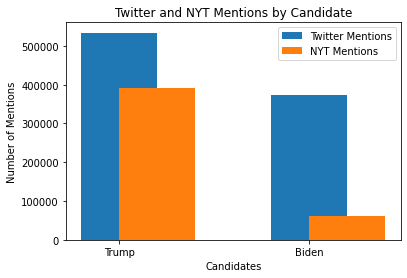

In [36]:
# Data Sources for Each Candidate
# Code from ChatGPT

import matplotlib.pyplot as plt

candidate = ['Trump','Biden']
twitter_n = [df_parquet_results_trump['source'].value_counts()[0],df_parquet_results_biden['source'].value_counts()[0]]
nyt_n = [df_parquet_results_trump['source'].value_counts()[1],df_parquet_results_biden['source'].value_counts()[1]]

x = range(len(candidate))

# Plotting the bars
plt.bar(x, twitter_n, width=0.4, label='Twitter Mentions', align='center')
plt.bar(x, nyt_n, width=0.4, label='NYT Mentions', align='edge')

# Adding labels
plt.xlabel('Candidates')
plt.ylabel('Number of Mentions')
plt.title('Twitter and NYT Mentions by Candidate')
plt.xticks(x, candidate)
plt.legend()

# Show plot
plt.savefig('DataDist.png')

## Standardizing Text Entries and Location Data

In [28]:
!pip install emoji

  Using cached emoji-2.11.0-py2.py3-none-any.whl.metadata (5.3 kB)
Using cached emoji-2.11.0-py2.py3-none-any.whl (433 kB)


In [43]:
import re
import emoji

# Function to preprocess text data
def preprocess_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text)
    # Replace emojis with text labels
    # text = emoji.demojize(text)
    # Remove URLs
    text = re.sub(r'http\S+', ' ', text)
    # Remove "#" from hashtags
    text = re.sub(r'#', '', text)
    # Remove "@" from mentions
    text = re.sub(r'@', '', text)
    # Remove extra spaces while preserving at least one space between words
    text = re.sub(r'\s+', ' ', text)
    # Check if the text consists only of numbers
    if text.isdigit():
        text = "NA"
    return text

df_parquet_results_biden['user_location'] = df_parquet_results_biden['user_location'].astype(str)
df_parquet_results_trump['user_location'] = df_parquet_results_trump['user_location'].astype(str)


/tmp/ipykernel_15775/924197739.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parquet_results_biden['user_location'] = df_parquet_results_biden['user_location'].astype(str)


In [44]:
# Apply preprocessing to text columns in the dataframe
df_parquet_results_biden['clean_text'] = df_parquet_results_biden['comment_body'].apply(preprocess_text)

/tmp/ipykernel_15775/3431105715.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parquet_results_biden['clean_text'] = df_parquet_results_biden['comment_body'].apply(preprocess_text)


In [45]:
df_parquet_results_biden['clean_location'] = df_parquet_results_biden['user_location'].apply(preprocess_text)

/tmp/ipykernel_15775/400958404.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parquet_results_biden['clean_location'] = df_parquet_results_biden['user_location'].apply(preprocess_text)


In [46]:
df_parquet_results_trump['clean_text'] = df_parquet_results_trump['comment_body'].apply(preprocess_text)

In [47]:
df_parquet_results_trump['clean_location'] = df_parquet_results_trump['user_location'].apply(preprocess_text)

,comment_body,source,user_location,candidatepoll,clean_text,clean_location
0,Why does trump lie?,nyt_comment,Los Angeles,Trump,Why does trump lie,Los Angeles
1,American colonists fought a bloody revolution ...,nyt_comment,Camas WA,Trump,American colonists fought a bloody revolution ...,Camas WA
2,"""Oh Bret. You just cant let go can you? Always...",nyt_comment,LINY,Trump,Oh Bret You just cant let go can you Always l...,LINY
3,"""Trumpism has demonstrated that a large part o...",nyt_comment,usa,Trump,Trumpism has demonstrated that a large part o...,usa
4,"""The Trump administration has been a disaster ...",nyt_comment,California,Trump,The Trump administration has been a disaster ...,California
5,"""Yep! Trump's ignored most of his administrati...",nyt_comment,minnesota,Trump,Yep Trump s ignored most of his administratio...,minnesota
6,Who is this Trump who can eat people alive in ...,nyt_comment,Florida,Trump,Who is this Trump who can eat people alive in ...,Florida
7,You don’t need to love joe. You just need to d...,nyt_comment,Sunny Cal,Trump,You don t need to love joe You just need to do...,Sunny Cal
8,"""Instead of Trump's worthless nightly news and...",nyt_comment,minnesota,Trump,Instead of Trump s worthless nightly news and...,minnesota
9,"""@John It is so bizarre that a lot of the same...",nyt_comment,Atlanta GA,Trump,John It is so bizarre that a lot of the same ...,Atlanta GA


# Word Clouds with Comment Body Text

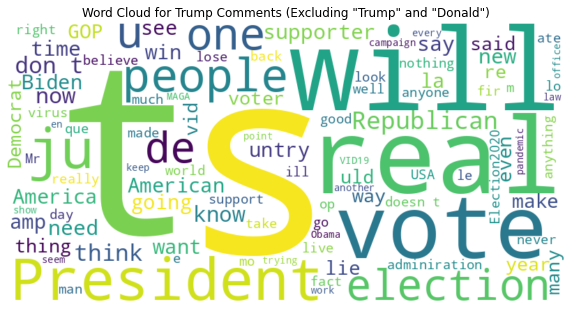

In [48]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# Sample a subset of comments for generating the word cloud
sampled_trump_comments = df_parquet_results_trump['clean_text'].dropna().sample(n=10000, random_state=42)

# Concatenate sampled comments for Trump
trump_comments_text = ' '.join(sampled_trump_comments)

# Define words and patterns to exclude
words_to_exclude = ['trump', 'donald', 'donaldtrump', 'https', 'co', 'st'] 
patterns_to_exclude = [r'\btrump\b', r'\bdonald\b', r'\bdonaldtrump\b', r'https?://\S+']

# Combine words and patterns to exclude
exclude_patterns = '|'.join(words_to_exclude + patterns_to_exclude)

# Preprocess text to remove specific words and patterns
trump_comments_text_cleaned = re.sub(exclude_patterns, '', trump_comments_text, flags=re.IGNORECASE)

# Generate word cloud for Trump comments with a limit on the number of words
wordcloud_trump = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(trump_comments_text_cleaned)

# Plot the word cloud for Trump
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_trump, interpolation='bilinear')
plt.title('Word Cloud for Trump Comments (Excluding "Trump" and "Donald")')
plt.axis('off')
plt.show()

In [ ]:
# Sample a subset of comments for Biden
sampled_biden_comments = df_parquet_results_biden['clean_text'].dropna().sample(n=40000, random_state=42)

# Concatenate sampled comments for Biden
biden_comments_text = ' '.join(sampled_biden_comments)

# Define words and patterns to exclude
words_to_exclude = ['biden', 'joe', 'joebiden', 'president', 'election', 'https', 'co','amp']  # Exclude common words and URLs
patterns_to_exclude = [r'\bbiden\b', r'\bjoe\b', r'\bjoebiden\b', r'https?://\S+']

# Combine words and patterns to exclude
exclude_patterns = '|'.join(words_to_exclude + patterns_to_exclude)

# Preprocess text to remove specific words and patterns
biden_comments_text_cleaned = re.sub(exclude_patterns, '', biden_comments_text, flags=re.IGNORECASE)

# Generate word cloud for Biden comments with a limit on the number of words
wordcloud_biden = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(biden_comments_text_cleaned)

# Plot the word cloud for Biden
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_biden, interpolation='bilinear')
plt.title('Word Cloud for Biden Comments (Excluding "Biden" and "Joe")')
plt.axis('off')
plt.show()

# Feature Transformation and Data Cleaning

### Sentiment Labels Using Textblob and Stripping Out Non-English Text Entries with Fasttext.

### This code must be ran on Mac/Linux only. Windows is not compatible. Clean data from this code is stored in an S3 bucket and called below.

In [ ]:
#pip install langdetect

In [ ]:
#pip install fasttext-wheel

In [35]:
#Use pretrained model
!pip install textblob
#!wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin -P /ADS508_GroupProject
#!ls -p /ADS508_GroupProject


  Using cached textblob-0.18.0.post0-py3-none-any.whl.metadata (4.5 kB)
Using cached textblob-0.18.0.post0-py3-none-any.whl (626 kB)


In [ ]:
#import fasttext
# Load the pre-trained language identification model
#model_path = '/ADS508_GroupProject/lid.176.bin'  # Path to the pre-trained language identification model
#model = fasttext.load_model(model_path)

In [ ]:
# Function to detect language using FastText
#def detect_language_fasttext(text):
#    prediction = model.predict(text)
#    language_code = prediction[0][0].split('__label__')[1]
#    return language_code

# Function to analyze tweet sentiment to catch non english words
#def analyze_tweet_sentiment(tweet_text):
#    try:
#        language = detect_language_fasttext(tweet_text)
#        if language == 'en':
#            analysis = TextBlob(tweet_text)
#            return analysis.sentiment.polarity
#        else:
#            return None
#    except:
#        return None



In [49]:

from textblob import TextBlob
def analyze_tweet_sentiment(tweet_text):
    analysis = TextBlob(tweet_text)
    # Return sentiment polarity (ranging from -1 to 1)
    return analysis.sentiment.polarity

In [50]:
# Apply sentiment labels to Trump Data
if __name__ == "__main__":
    # Assuming you have a DataFrame named df_tweets with a column 'text' containing tweet text
    df_tweets_trump = df_parquet_results_trump[['clean_text']]
    # Analyze sentiment for each tweet in the DataFrame
    df_tweets_trump['sentiment_score'] = df_tweets_trump['clean_text'].apply(analyze_tweet_sentiment)

# Add sentiment output to parent dataframe
df_parquet_results_trump['sentiment'] = df_tweets_trump['sentiment_score']

/tmp/ipykernel_15775/4017857091.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_trump['sentiment_score'] = df_tweets_trump['clean_text'].apply(analyze_tweet_sentiment)


In [51]:
 # Apply Sentiment labels to Biden Data       
if __name__ == "__main__":
    # Assuming you have a DataFrame named df_tweets with a column 'text' containing tweet text
    df_tweets_biden = df_parquet_results_biden[['clean_text']]
    # Analyze sentiment for each tweet in the DataFrame
    df_tweets_biden['sentiment_score'] = df_tweets_biden['clean_text'].apply(analyze_tweet_sentiment)

# Add sentiment output to parent dataframe
df_parquet_results_biden['sentiment'] = df_tweets_biden['sentiment_score']


/tmp/ipykernel_15775/2765627512.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_biden['sentiment_score'] = df_tweets_biden['clean_text'].apply(analyze_tweet_sentiment)
/tmp/ipykernel_15775/2765627512.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parquet_results_biden['sentiment'] = df_tweets_biden['sentiment_score']


In [52]:
df_parquet_results_trump.head(5)

,comment_body,source,user_location,candidatepoll,clean_text,clean_location,sentiment
0,"""Ma la signora Maglie che nelle sue dirette ci...",tweet,<NA>,Trump,Ma la signora Maglie che nelle sue dirette ci...,NA,0.000000
1,#ByeByeTrump #Election2020results #Election202...,tweet,HE%SHE ☆ﾐ,Trump,ByeByeTrump Election2020results Election2020 ...,HE SHE ﾐ,0.000000
2,"""Finally a real president! Trump supporters",tweet,<NA>,Trump,Finally a real president Trump supporters,NA,0.200000
3,"""#ByeByeTrump you are gefeuert..",tweet,<NA>,Trump,ByeByeTrump you are gefeuert,NA,0.000000
4,"""Trump be like : accha main chlta hu duao main...",tweet,<NA>,Trump,Trump be like accha main chlta hu duao main y...,NA,0.166667


## Combine candidate data

In [53]:
df_combined = pd.concat([df_parquet_results_biden, df_parquet_results_trump], ignore_index=True)

### Create sentiment labels

In [54]:
df_combined['sentiment_category'] = df_combined['sentiment'].apply(lambda x: 'negative' if x < 0 else ('positive' if x > 0 else 'neutral'))

In [55]:
df_combined.head()

,comment_body,source,user_location,candidatepoll,clean_text,clean_location,sentiment,sentiment_category
0,We can all breathe now . #Biden,tweet,NY 🍎 LA | 🌎 Traveler | Not All Those Who Wan,Biden,We can all breathe now Biden,NY LA Traveler Not All Those Who Wan,0.00,neutral
1,#KamalaHarrisVP #JoeBiden JOE AND KAMALA DO ...,tweet,,Biden,KamalaHarrisVP JoeBiden JOE AND KAMALA DO NOT...,,0.33,positive
2,Thank you @KingJames @CP3 &amp; the sporting w...,tweet,,Biden,Thank you KingJames CP3 amp the sporting world...,,0.00,neutral
3,"""@BBCNews #JoeBiden can we please savour this ...",tweet,158.0,Biden,BBCNews JoeBiden can we please savour this mo...,158 0,0.00,neutral
4,#Merkel #Allemagne #Biden https://t.co/fyq8r3siwN,tweet,"""Montréal",Biden,Merkel Allemagne Biden t co fyq8r3siwN,Montréal,0.00,neutral


In [56]:
df_combined.shape

(1361610, 8)

# Additional EDA with Clean Language Data

## Trump Data

In [ ]:
# Examine Trump Sentiment distribution
df_combined[df_combined['candidatepoll'] == 'Trump']['sentiment'].value_counts()

In [ ]:
df_combined[(df_combined['candidatepoll'] == 'Trump') & (df_combined['sentiment'] < 0)].head(5)

In [ ]:
df_combined[(df_combined['candidatepoll'] == 'Trump') & (df_combined['sentiment'] == 0)].head(5)

In [ ]:
df_combined[(df_combined['candidatepoll'] == 'Trump') & (df_combined['sentiment'] > 0)].head(5)

In [ ]:
plt.hist(df_combined[df_combined['candidatepoll'] == 'Trump']['sentiment'], bins=30, edgecolor='black')

# Adding labels
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores for Trump')

# Show plot
plt.savefig('TrumpSentDist.png')

### Biden Data

In [ ]:
df_combined[df_combined['candidatepoll'] == 'Biden']['sentiment'].value_counts()

In [ ]:
df_combined[(df_combined['candidatepoll'] == 'Biden') & (df_combined['sentiment'] < 0)].head(5)

In [ ]:
df_combined[(df_combined['candidatepoll'] == 'Biden') & (df_combined['sentiment'] == 0)].head(5)

In [ ]:
df_combined[(df_combined['candidatepoll'] == 'Biden') & (df_combined['sentiment'] > 0)].head(5)

In [ ]:
plt.hist(df_combined[df_combined['candidatepoll'] == 'Biden']['sentiment'], bins=30, edgecolor='black')

# Adding labels
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores for Biden')

# Show plot
plt.savefig('BidenSentDist.png')

## Data Source Proportions with Clean Data

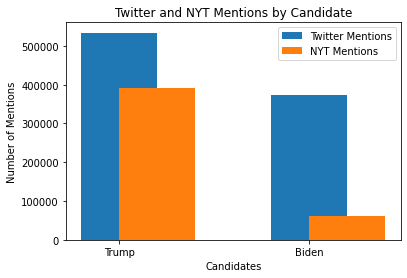

In [57]:
candidate = ['Trump','Biden']
twitter_n = [df_combined[df_combined['candidatepoll'] == 'Trump']['source'].value_counts()[0], 
             df_combined[df_combined['candidatepoll'] == 'Biden']['source'].value_counts()[0]]
nyt_n = [df_combined[df_combined['candidatepoll'] == 'Trump']['source'].value_counts()[1], 
         df_combined[df_combined['candidatepoll'] == 'Biden']['source'].value_counts()[1]]

x = range(len(candidate))

# Plotting the bars
plt.bar(x, twitter_n, width=0.4, label='Twitter Mentions', align='center')
plt.bar(x, nyt_n, width=0.4, label='NYT Mentions', align='edge')

# Adding labels
plt.xlabel('Candidates')
plt.ylabel('Number of Mentions')
plt.title('Twitter and NYT Mentions by Candidate')
plt.xticks(x, candidate)
plt.legend()

# Show plot
plt.savefig('DataDist.png')

# Additional Feature Engineering

## Create Outcome Variable

In [ ]:
df_combined['SentimentOutcome'] = df_combined['candidatepoll']+"_"+df_combined['sentiment_category']

In [58]:
import matplotlib.pyplot as plt
category_counts = df_combined['SentimentOutcome'].value_counts()
plt.bar(category_counts.index, category_counts.values)
plt.xlabel('Candidate Sentiment Categories')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.ylabel('Count')
plt.title('Frequency of Each Possible Sentiment Outcome')
plt.show()

KeyError: 'SentimentOutcome'

## Smallest category is Biden_negative. Check number. When using train/test/split with 90/5/5 ratio, we will have to balance categories to observationse each based on 90% of the smallest category.

In [ ]:
 df_combined[df_combined['candidatepoll'] == 'Biden']['SentimentOutcome'].value_counts()

In [ ]:
 df_combined[df_combined['candidatepoll'] == 'Trump']['SentimentOutcome'].value_counts()

## Mapping Location Data and Map EDA. NEED TO TROUBLESHOOT THIS STILL.

---> TRYING WITH SQL

In [36]:
df_combined.head(5)


,comment_body,source,user_location,candidatepoll,clean_text,clean_location,sentiment,sentiment_category
0,"""@Dr. Girl We only just barely got BIDEN elect...",nyt_comment,Maryland,Biden,Dr Girl We only just barely got BIDEN elected...,Maryland,0.183333,positive
1,I've always thought Joe Biden was underrated. ...,nyt_comment,Indiana,Biden,I ve always thought Joe Biden was underrated S...,Indiana,0.500000,positive
2,"""I’ve seen a lot of Biden in the last few week...",nyt_comment,Whitestown IN,Biden,I ve seen a lot of Biden in the last few week...,Whitestown IN,0.166667,positive
3,"""In the midst of today's press conference at t...",nyt_comment,Eureka CA,Biden,In the midst of today s press conference at t...,Eureka CA,0.000000,neutral
4,"""When is Biden going to start campaigning?",nyt_comment,Kentucky,Biden,When is Biden going to start campaigning,Kentucky,0.000000,neutral


In [42]:
# Specify the S3 bucket name
prefix = "ADS508_project/cleandata/"

# List of corresponding file names
file_name = "cleandata.csv"

# Create an S3 client
s3 = boto3.client('s3')

#refine df_combined
df_combined_ref = df_combined[['source', 'clean_text', 'clean_location', 'candidatepoll', 'sentiment_category']]
df_combined_ref.head()


,source,clean_text,clean_location,candidatepoll,sentiment_category
0,nyt_comment,Dr Girl We only just barely got BIDEN elected...,Maryland,Biden,positive
1,nyt_comment,I ve always thought Joe Biden was underrated S...,Indiana,Biden,positive
2,nyt_comment,I ve seen a lot of Biden in the last few week...,Whitestown IN,Biden,positive
3,nyt_comment,In the midst of today s press conference at t...,Eureka CA,Biden,neutral
4,nyt_comment,When is Biden going to start campaigning,Kentucky,Biden,neutral


In [43]:
# Upload each file to S3
df_combined_ref.to_csv(file_name, index=False)
s3.upload_file(file_name, bucket, prefix + file_name)

In [44]:
# Create temp table since always get "NOT_SUPPORTED: Modifying Hive table rows is only supported for transactional tables unable to rollback"
temp_table = "temp_table"
s3_private_path_cleandata = "s3://{}/ADS508_project/cleandata".format(bucket)

statement = """
CREATE EXTERNAL TABLE IF NOT EXISTS {}.{} (
    source VARCHAR(20),
    clean_text VARCHAR(250),
    clean_location VARCHAR(25),
    candidatepoll VARCHAR(10),
    sentiment_category VARCHAR(10)
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')
""".format(
    database_name, temp_table, s3_private_path_cleandata
)

pd.read_sql(statement, conn)

/tmp/ipykernel_97/1575907856.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


""


In [46]:
# Create a combine cleandata with uscities since AWS Athena doesn't support update
table_name = "cleandata"
import time
from datetime import datetime
from time import strftime
timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
print(f"start: {timestamp}\n")

statement = """
CREATE TABLE IF NOT EXISTS {}.{} AS (
SELECT DISTINCT t.*, u.state_id
    FROM  dbpoliticpulsecomment.temp_table t
    LEFT JOIN dbpoliticpulsecomment.uscities u
        on lower(t.clean_location) = lower(u.city)
        OR lower(t.clean_location) = lower(u.state_name)
        OR lower(t.clean_location) = lower(u.state_id)
)
""".format(database_name, table_name)
pd.read_sql(statement, conn)
timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
print(f"end: {timestamp}\n")

start: 2024-03-26T22:48:22Z



/tmp/ipykernel_97/2930279652.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


DatabaseError: Execution failed on sql: 
CREATE TABLE IF NOT EXISTS dbpoliticpulsecomment.cleandata AS (
SELECT DISTINCT t.*, u.state_id
    FROM  dbpoliticpulsecomment.temp_table t
    LEFT JOIN dbpoliticpulsecomment.uscities u
        on lower(t.clean_location) = lower(u.city)
        OR lower(t.clean_location) = lower(u.state_name)
        OR lower(t.clean_location) = lower(u.state_id)
)

Query timeout. You may need to manually clean the data at location 's3://sagemaker-us-west-2-471112815505/athena/staging/tables/e3ffc3f3-8727-4e79-98de-9b53030416c3' before retrying. Athena will not delete data in your account.
unable to rollback

In [ ]:
temp_table = "temp_table"
statement = """
DROP TABLE {}.{}
""".format(database_name, temp_table)
pd.read_sql(statement, conn)

In [ ]:
#==> SHOULD CREATE ANOTHER PARQUET OR READING FROM THIS? 
statement = """SELECT * FROM {}.{}""".format(
    database_name, table_name
)
#df_combined = pd.read_sql(statement, conn)
df_combined.head(5)

---> USING PYTHON AND TOOK FOREVER

In [28]:
# Read csv US City from S3 ---> PLANNING TO MOVE IT IN .py AND USE PREPROCESSING JOB FROM SAGEMAKER
git_city_loc = "https://raw.githubusercontent.com/HNStaggs/ADS508_GroupProject/main/uscities.csv"
df_city = pd.read_csv(git_city_loc)

#df_parquet_results_trump['clean_location'].head(15000)
df_parquet_results_trump1 = df_parquet_results_trump.head(100)
df_parquet_results_trump1.head(10)

,comment_body,source,user_location,candidatepoll,clean_text,clean_location,sentiment
0,"""@Dr. Girl We only just barely got BIDEN elect...",nyt_comment,Maryland,Biden,Dr Girl We only just barely got BIDEN elected...,Maryland,0.183333
1,I've always thought Joe Biden was underrated. ...,nyt_comment,Indiana,Biden,I ve always thought Joe Biden was underrated S...,Indiana,0.500000
2,"""I’ve seen a lot of Biden in the last few week...",nyt_comment,Whitestown IN,Biden,I ve seen a lot of Biden in the last few week...,Whitestown IN,0.166667
3,"""In the midst of today's press conference at t...",nyt_comment,Eureka CA,Biden,In the midst of today s press conference at t...,Eureka CA,0.000000
4,"""When is Biden going to start campaigning?",nyt_comment,Kentucky,Biden,When is Biden going to start campaigning,Kentucky,0.000000
5,@Yeah The corroborating evidence is much stron...,nyt_comment,Somewhere,Biden,Yeah The corroborating evidence is much stron...,Somewhere,0.200000
6,What happened to Bloomberg's promise to put hi...,nyt_comment,Los Angeles CA,Biden,What happened to Bloomberg s promise to put hi...,Los Angeles CA,0.250000
7,"""@sharpshin How naive are you? Once Biden won ...",nyt_comment,Rocky Mountains,Biden,sharpshin How naive are you Once Biden won S C,Rocky Mountains,-0.300000
8,"""Maybe the problem in this conversation is bei...",nyt_comment,Portland Oregon,Biden,Maybe the problem in this conversation is bei...,Portland Oregon,-0.126488
9,Biden's on a fast track. A gift - finally some...,nyt_comment,New York,Biden,Biden s on a fast track A gift finally somethi...,New York,0.100000


In [29]:
# PREFER TO RUN IT IN .py with SageMaker processing job
# TRY IT WITH 10000 RECORD took FOREVER

import time
from datetime import datetime
from time import strftime
timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
print(f"start: {timestamp}\n")

# Create master location table
git_city_loc = "https://raw.githubusercontent.com/HNStaggs/ADS508_GroupProject/main/uscities.csv"
df_city = pd.read_csv(git_city_loc)
master_location = df_city

# Function to map city and state name to state ID
def map_state_id(city):
    for index, loc in master_location.iterrows():
        if city.lower() == loc['city'].lower() or city.lower() == loc['state_name'].lower():
            return loc['state_id']
    return None

# Apply mapping function to user location table
#df_parquet_results_trump1['final_location'] = df_parquet_results_trump1['clean_location'].apply(map_state_id)  # Use clean location data from primary cleaning step

# Display the user location table with State ID column added
timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")

print(f"end: {timestamp}\n")


start: 2024-03-26T14:49:24Z

end: 2024-03-26T17:48:22Z



/tmp/ipykernel_98/218112506.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parquet_results_trump1['final_location'] = df_parquet_results_trump1['clean_location'].apply(map_state_id)  # Use clean location data from primary cleaning step


In [31]:
df_parquet_results_trump1.shape

(10000, 8)

In [ ]:
### working progress.. still need to check##
from sagemaker.processing import ScriptProcessor

# Create a ScriptProcessor object
script_processor = ScriptProcessor(base_job_name='data-processing',
                                   image_uri=None,
                                   command=['python3'],
                                   instance_count=1,
                                   instance_type='ml.m5.xlarge',
                                   role=role)

# Specify the entry script
entry_script = 's3://sagemaker-us-west-2-471112815505/ADS508_project/script/process_loc.py'

# Run the processing job
script_processor.run(code=entry_script)


In [ ]:
# Data Vis
# # creat colored maps by state based on sentiment

In [ ]:
# Determime sample size from each state

In [ ]:
# Determine portion of Trump/Biden for each state

# Data Partition

### Assign input and outcome variables

In [ ]:
X = df_combined[['clean_text']]  # Add location back in later
y = df_combined['SentimentOutcome']

### Create a 90/5/5 data split

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into 90% train and 10% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Split remaining data (90% train) into 90% train and 10% validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/9, random_state=1)

### Further undersample the training set so that each level of the outcome variable is equal

In [ ]:
#!pip install imblearn
from imblearn.under_sampling import RandomUnderSampler

# Undersample the training set to balance the six categorical outcome levels
undersampler = RandomUnderSampler(sampling_strategy='all', random_state=1)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

## Verify split datasets size

In [ ]:
X_train_resampled.info()

In [ ]:
X_test.info()

In [ ]:
X_val.info()

In [ ]:
X_train_resampled.shape, X_test.shape, X_val.shape

In [ ]:
X_train_resampled.head()

In [ ]:
X_test.head()

In [ ]:
X_val.head()

## Verify balance of training set

In [ ]:
y_train_resampled.value_counts()

## Average length of comments. Limit word vectors to median length of 15.

In [ ]:
# Function to count string word length
def count_word_length(text):
    words = text.split()
    return len(words)

# Add column to DataFrame
df_combined['word_length'] = df_combined['clean_text'].apply(lambda x: count_word_length(x))

In [ ]:
import numpy as np
median_word_length = np.median(df_combined['word_length'])

# Plot histogram of word lengths
plt.hist(df_combined['word_length'], bins=range(min(df_combined['word_length']), max(df_combined['word_length']) + 1), edgecolor='black')
plt.axvline(median_word_length, color='red', linestyle='dashed', linewidth=1)  # Add vertical line at median
plt.text(median_word_length, plt.ylim()[1] * 0.9, f'Median: {median_word_length:.2f}', color='red')  # Add label for median
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.title('Histogram of Word Lengths')
plt.grid(True)
plt.show()

# Text Entry Preprocessing and Data Transformation Pipeline: Will Need to Add Categorical One-Hot Encoding if we use Location Data

In [ ]:
#!pip install gensim
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from gensim.models import Word2Vec

# Define custom transformer for Word2Vec embeddings
class Word2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, window=5, min_count=1, workers=4):
        self.word2vec_model = Word2Vec(window=window, min_count=min_count, workers=workers)
    
    def fit(self, X, y=None):
        # Train Word2Vec model
        X_word_lists = [text.split()[:15] for text in X]  # Limit to first 15 words
        self.word2vec_model.build_vocab(X_word_lists)
        self.word2vec_model.train(X_word_lists, total_examples=len(X_word_lists), epochs=10)
        return self
    
    def transform(self, X):
        # Limit text to first 15 words and split into word lists
        X_word_lists = [text.split()[:15] for text in X]
        # Initialize a list to store word embeddings
        embeddings = []
        # Iterate over each word list
        for word_list in X_word_lists:
            # Initialize a list to store word embeddings for this word list
            word_embeddings = []
            # Iterate over each word in the word list
            for word in word_list:
                # Check if the word exists in the Word2Vec model's vocabulary
                if word in self.word2vec_model.wv:
                    # Retrieve the word embedding and append it to the list
                    word_embeddings.append(self.word2vec_model.wv[word])
                else:
                    # If the word doesn't exist in the vocabulary, append zeros
                    word_embeddings.append([0] * self.word2vec_model.vector_size)
            # Append the word embeddings for this word list to the embeddings list
            embeddings.append(word_embeddings)
        return embeddings

# Define preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('word2vec', Word2VecTransformer())
])

In [ ]:
# Fit and transform on the training set
X_train_transformed = pd.DataFrame(preprocessing_pipeline.fit_transform(X_train_resampled['clean_text']))

In [ ]:
X_test_transformed = pd.DataFrame(preprocessing_pipeline.transform(X_test['clean_text'])) 

In [ ]:
X_val_transformed = pd.DataFrame(preprocessing_pipeline.transform(X_val['clean_text']))

In [ ]:
X_train_transformed.head()

In [ ]:
X_test_transformed.head()

In [ ]:
X_val_transformed.head()

# Store Data For Modeling in Bucket

In [ ]:
#import boto3

# Specify the S3 bucket name
bucket_name = '508group_modeling'
    
# List of DataFrame objects
dataframes = [X_train_transformed, y_train, X_test_transformed, y_test, X_val_transformed, y_val]

# List of corresponding file names
file_names = ['X_train_transformed.csv', 'y_train.csv', 'X_test_transformed.csv', 'y_test.csv', 'X_val_transformed.csv', 'y_val.csv']

# Create an S3 client
s3 = boto3.client('s3')

# Upload each file to S3
for df, file_name in zip(dataframes, file_names):
    # Write DataFrame to a CSV file
    df.to_csv(file_name, index=False)
    
    # Upload CSV file to S3
    with open(file_name, "rb") as f:
        s3.upload_fileobj(f, bucket_name, file_name)

    print(f"DataFrame saved as {file_name} in S3 bucket: {bucket_name}")

# Import Data for Modeling

In [ ]:
import boto3
import pandas as pd

# Specify the S3 bucket name
bucket_name = '508group_modeling'

# List of file names in S3
file_names = ['X_train_transformed.csv', 'y_train.csv', 'X_test_transformed.csv', 
              'y_test.csv', 'X_val_transformed.csv', 'y_val.csv']

# Create an S3 client
s3 = boto3.client('s3')

# Initialize variables to store DataFrames
X_train = None
y_train = None
X_test = None
y_test = None
X_val = None
y_val = None

# Iterate over each file name
for i, file_name in enumerate(file_names):
    # Generate the URL for the file in S3
    file_url = f's3://{bucket_name}/{file_name}'
    
    # Read the CSV file directly into a DataFrame
    df = pd.read_csv(file_url)
    
    # Assign the DataFrame to the corresponding variable based on index
    if i == 0:
        X_train = df
    elif i == 1:
        y_train = df
    elif i == 2:
        X_test = df
    elif i == 3:
        y_test = df
    elif i == 4:
        X_val = df
    elif i == 5:
        y_val = df

## Verify contents of DFs

In [ ]:
X_train.head()

In [ ]:
y_train.head()

In [ ]:
X_test.head()

In [ ]:
y_test.head()

In [ ]:
X_val.head()

In [ ]:
y_val.head()

## Modeling 

In [ ]:
import sagemaker
from sagemaker.tensorflow import TensorFlow

#Simple sagemaker tens

# Specify the S3 bucket name
bucket_name = '508group_modeling'

# Define paths to your training, validation, and test data
train_data = f's3://{bucket_name}/X_train_transformed.csv'
validation_data = f's3://{bucket_name}/X_val_transformed.csv'
test_data = f's3://{bucket_name}/X_test_transformed.csv'

# Define SageMaker TensorFlow Estimator
estimator = TensorFlow(entry_point='train.py',
                       role=sagemaker.get_execution_role(),
                       instance_count=1,
                       instance_type='ml.p3.2xlarge',
                       framework_version='2.3.1',
                       py_version='py37',
                       script_mode=True,
                       hyperparameters={
                           'epochs': 10,
                           'batch_size': 64,
                           'learning_rate': 0.001
                       })

# Train  model
estimator.fit({'train': train_data, 'validation': validation_data})

# Deploy the trained model
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m5.large')



## Run Data Bias Analysis

In [ ]:
# Create folder for specific timestamp
import time

timestamp = int(time.time())

bias_data_s3_uri = sess.upload_data(bucket=bucket, key_prefix="ADS508_project/bias-detection-{}".format(timestamp), path=path)
bias_data_s3_uri

In [ ]:
!aws s3 ls $bias_data_s3_uri

In [ ]:
balanced_bias_data_s3_uri = sess.upload_data(
    bucket=bucket, key_prefix="ADS508_project/bias-detection-{}".format(timestamp), path=path_balance
)
balanced_bias_data_s3_uri

In [ ]:
!aws s3 ls $balanced_bias_data_s3_uri

In [ ]:
balanced_bias_data_jsonlines_s3_uri = sess.upload_data(
    bucket=bucket, key_prefix="ADS508_project/bias-detection-{}".format(timestamp), path=path_jsonlines
)
balanced_bias_data_jsonlines_s3_uri

In [ ]:
!aws s3 ls $balanced_bias_data_jsonlines_s3_uri

In [ ]:
#!pip install --force-reinstall -q smclarify

from smclarify.bias import report
from typing import Dict
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
!aws s3 cp $bias_data_s3_uri ./data-clarify/

In [ ]:
!aws s3 cp $balanced_bias_data_s3_uri ./data-clarify/

### Calculate Bias Metrics for all Data
#### might not needed from ===>

facet_column = report.FacetColumn(name="candidatepoll")

label_column = report.LabelColumn(
    name="sentiment_category", 
    series=df_combined["sentiment_category"],
    positive_label_values=[5]
)

In [ ]:
report.bias_report(
    df=df_combined, 
    facet_column=facet_column, 
    label_column=label_column, 
    stage_type=report.StageType.PRE_TRAINING, 
    metrics=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"]
)

### Calculate Bias Metrics for Balanced Data

In [ ]:
from smclarify.bias import report

facet_column = report.FacetColumn(name="candidatepoll")

label_column = report.LabelColumn(
    name="sentiment_category", 
    series=df_balanced["sentiment_category"], 
    positive_label_values=[5]
)

In [ ]:
report.bias_report(
    df=df_balanced, 
    facet_column=facet_column, 
    label_column=label_column, 
    stage_type=report.StageType.PRE_TRAINING, 
    metrics=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"]
)

#### <=== TO MIGHT NOT NEEDED

### Run Data Bias Analysis (Pre-training)

In [ ]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, 
    instance_count=1, 
    instance_type="ml.c5.xlarge", 
    sagemaker_session=sess
)

#### Pre-Training Bias

In [ ]:
bias_report_output_path = "s3://{}/ADS508_project/clarify".format(bucket)

bias_data_config = clarify.DataConfig(
    s3_data_input_path=bias_data_s3_uri,
    s3_output_path=bias_report_output_path,
    label="sentiment_category",
    headers=df_combined.columns.to_list(),
    dataset_type="text/csv",
)


In [ ]:
# Trump
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[5],
    facet_name="candidatepoll",
    facet_values_or_threshold=["Trump"],
)

clarify_processor.run_pre_training_bias(
    data_config=bias_data_config, 
    data_bias_config=bias_config, 
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False, 
    logs=False
)

run_pre_training_bias_processing_job_name = clarify_processor.latest_job.job_name
run_pre_training_bias_processing_job_name



In [ ]:
# Biden
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[5],
    facet_name="candidatepoll",
    facet_values_or_threshold=["Biden"],
)

clarify_processor.run_pre_training_bias(
    data_config=bias_data_config, 
    data_bias_config=bias_config, 
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False, 
    logs=False
)

run_pre_training_bias_processing_job_name = clarify_processor.latest_job.job_name
run_pre_training_bias_processing_job_name


#### Download report

In [ ]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">Processing Job</a></b>'.format(
            region, run_pre_training_bias_processing_job_name
        )
    )
)
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a> After About 5 Minutes</b>'.format(
            region, run_pre_training_bias_processing_job_name
        )
    )
)

from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 Output Data</a> After The Processing Job Has Completed</b>'.format(
            bucket, run_pre_training_bias_processing_job_name, region
        )
    )
)

In [ ]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(
    processing_job_name=run_pre_training_bias_processing_job_name, sagemaker_session=sess
)

processing_job_description = running_processor.describe()

print(processing_job_description)

In [ ]:
!aws s3 ls $bias_report_output_path/

In [ ]:
!aws s3 cp --recursive $bias_report_output_path ./generated_bias_report/

In [ ]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="./generated_bias_report/report.html">Bias Report</a></b>'))

In [ ]:
path = "./data-clarify/amazon_reviews_us_giftcards_software_videogames.csv"
df.to_csv(path, index=False, header=True)

In [ ]:
_testing